# Predicción del resultado de partidas de ajedrez a partir de su metadata.

**Palabras clave:**

- **ELO:** valor numérico que determina la fuerza de un jugador de ajedrez. En Costa Rica, se inicia con 1400 puntos y se alcanza la Primera División con un ELO de 2000, mientras que el campeón nacional tiene una fuerza cercana a 2400. El campeón del mundo, actualmente, posee un ELO de 2855. 
- **Lichess:** sitio web *open-source* muy popular para jugar ajedrez en línea, con millones de partidas jugadas cada mes. En Internet, los ELOs tienden a ser más altos (debido a las mecánicas que utilizan las páginas para calcularlo).
- **Apertura:** primeras jugadas que se realizan en una partida de ajedrez. Típicamente, corresponde a las primeras 10 o 15 movidas.
- **ECO:** *Encyclopedia of Chess Openings*; clasificación alfanumérica para todas las aperturas posibles en el ajedrez. Cada código consta de una letra (de la A a la E) seguida de dos dígitos.
- **Control de tiempo:** minutos que posee cada jugador para la partida. Una partida *bullet* significa 1 minuto por jugador; una partida *blitz* consta de 5 minutos por jugador.
- **Tablas:** empate en ajedrez.
- **PGN:** *Portable Game Notation*; extensión de archivo especializado para programas diseñados para trabajar con material de ajedrez.

## 1. Descripción del problema y justificación del enfoque a utilizar

Con base en las características de una partida de ajedrez (ELO de sus jugadores, apertura jugada, control de tiempo empleado, cantidad de jugadas, entre otros) se desea predecir quién ganó el juego. Para esto, se utilizarán técnicas de aprendizaje automático para clasificación binaria, donde "1" significa victoria de las Blancas, mientras que "0" significa victoria de las Negras. En este trabajo, no se tomarán en cuenta las partidas que terminaron en tablas, por lo que una clasificación binaria se ajusta bien al escenario planteado.

### Dataset a utilizar

Se utilizará un *dataset* obtenido de la página [Lichess.org](https://lichess.org/), con cerca de 20 000 partidas jugadas en septiembre del 2017. El *dataset* fue convertido de PGN a CSV por un usuario de Kaggle y se encuentra disponible en dicha página.

Puede encontrar el conjunto de datos a utilizar haciendo click en este [enlace](https://www.kaggle.com/datasnaek/chess).

## 2. Preprocesamiento y limpieza de datos

El preprocesamiento y limpieza de datos fue llevado a cabo con **OpenRefine**. Se adjunta en el repositorio el archivo *.json* con todos los cambios realizados al conjunto de datos.

### 2.a Eliminar todas las columnas que no se utilizarán.

Para disminuir el ruido que entrará al modelo de aprendizaje automático, se eliminaron todas las columnas en el *dataset* original que no se estudiarán en este trabajo. En específico, se eliminaron los siguientes *features*:

- id.
- created_at.
- last_move_at.
- victory_status.
- white_id.
- black_id. 
- opening_name.
- opening_ply.

### 2.b Eliminar todas las partidas cuyo resultado terminó en tablas.

Seguidamente, se eliminaron todas las filas cuyo valor en la columna *winner* era "draw". Para esto, se utilizó un *text facet* que encontró todas las filas *draw* y se removieron del conjunto de datos. Se eliminaron 950 filas, lo que representa el 4.74% del total de datos. Esto se realizó por tres razones:

1. Es un porcentaje lo suficientemente bajo como para justificar su eliminación del conjunto de datos.
2. En el presente trabajo, interesa construir un modelo que pueda predecir el ganador de una partida, no las posibilidades de entablar.
3. Al eliminar esta tercera opción como un posible resultado, se simplifica el problema de una clasificación multiclase a una clasificación binaria.

### 2.c Reordenar las columnas.

Para simplificar el código, se colocó la columna de respuesta (*winner*) en el extremo derecho del conjunto de datos.

## 3. Transformación de Datos

La transformación de datos fue llevada a cabo con **OpenRefine**. Se adjunta en el repositorio el archivo *.json* con todos los cambios realizados al conjunto de datos.

### 3.a Convertir columna *rated* a valor numérico.

La columna *rated* indica si el juego afectará el rating (es decir, el ELO) de los jugadores. Originalmente, sus valores eran strings de "TRUE" o "FALSE". Para convertir de estos valores categóricos a valores numéricos, se utilizó el siguiente código GREL:

```
if(value == "FALSE",0,1)
```

### 3.b Convertir columna *increment_code* a valor numérico.

El *feature* *increment_code* indica el control de tiempo de la partida. Por ejemplo, valor de "15+10" indica que cada jugador inicia con 15 minutos y, cada vez que realiza un movimiento, se le añaden 10 segundos. Para convertir esta cadena de texto a un valor numérico, se eliminó el incremento (es decir, los segundos que se obtienen con cada jugada) y dejar únicamente el tiempo base (los minutos). Para esto, se utilizó el siguiente código GREL:

```
value.replace(/\+.*/,'')
```

### 3.c Cambiar *opening_eco* a valor numérico.

El código ECO representa dos problemas para los modelos de aprendizaje automático: 1. es un valor alfanumérico; 2. existen 500 valores posibles. En este trabajo, se decidió simplificar el código ECO y agrupar por el primer símbolo, es decir, la letra (A,B,C,D o E) que se encuentra al inicio del código. Luego, se le asignó un número a cada letra (A = 1, B = 2, etc) para poder tener una entrada numérica en el modelo. De esta forma, un código ECO de A66 y otro de A32 terminarán con el mismo valor: 1.

Esta transformación se basa en la agrupación propia de los códigos ECO: las aperturas de la clase "A" son aperturas de flanco; la clase "B" contiene a las aperturas semiabiertas; el Gambito de Dama, por ejemplo, se encuentra en la clase "D". De esta forma, las aperturas bajo una misma letra en el código ECO no son tan distintas entre sí, lo que permite agruparlas para facilitar la transformación de datos. Para lograr esto, se utilizó el siguiente código GREL:

```
if(value.startsWith("A"),1,if(value.startsWith("B"),2,if(value.startsWith("C"),3,if(value.startsWith("D"),4,5))))
```



Luego del preprocesamiento y transformación de datos, se tienen los siguientes *features* con los que se trabajará:

- isRated.
- turns.
- timeControl.
- whiteRating.
- blackRating.
- openingECO.
- winner.

## 4. Análisis Exploratorio de Datos



Se cargan los datos desde la computadora local.

In [3]:

from google.colab import files
import pandas as pd
uploaded = files.upload()
data = pd.read_excel('ChessGames.xlsx')
data.to_csv(encoding='utf-8', index=False)
data.head()

Saving ChessGames.xlsx to ChessGames (1).xlsx


,isRated,turns,timeControl,whiteRating,blackRating,openingECO,winner
0,0,13,15,1500,1191,4,1
1,1,16,5,1322,1261,2,0
2,1,61,5,1496,1500,3,1
3,1,61,20,1439,1454,4,1
4,1,95,30,1523,1469,3,1


### 4.a Análisis Descriptivo

#### 4.a.1 Histograma de *whiteRating*

Para conocer la fuerza de los jugadores en el *dataset*, se graficará un histograma con los valores de *whiteRating*. Se esperaría que la figura resultante se asemeje a una distribución normal.

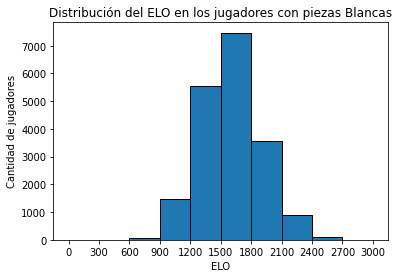

In [4]:
import matplotlib.pyplot as plt
plt.title('Distribución del ELO en los jugadores con piezas Blancas')
plt.xlabel('ELO')
plt.ylabel('Cantidad de jugadores')
bins= [0,300,600,900,1200,1500,1800,2100,2400,2700,3000]
plt.hist(data['whiteRating'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.show()

Como se puede apreciar, la fuerza de los jugadores sigue una distribución más o menos normal, En particular, la gran mayoría de jugadores se encuentran entre 1200 y 2100 puntos de ELO, siendo el rango con más jugadores el de 1500 a 1800 puntos. 

#### 4.a.2 Histograma de *winner*

Seguidamente, se desea conocer cuál color de piezas obtiene más victorias, mediante un histograma. En este caso, se espera una leve mayoría de victorias con las piezas Blancas.

En el eje x del siguiente gráfico, el "0" representa a las piezas Negras y el "1" a las piezas Blancas.

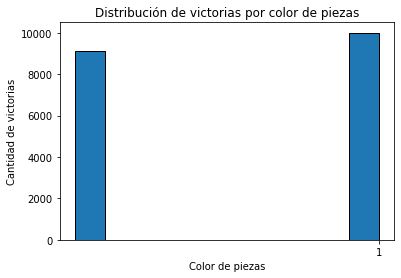

In [14]:
plt.title('Distribución de victorias por color de piezas')
plt.xlabel('Color de piezas')
plt.ylabel('Cantidad de victorias')
plt.hist(data['winner'],  edgecolor="k")
bins = [1]
plt.xticks(bins)
plt.show()

El gráfico confirma la suposición inicial: las Blancas ganan más partidas que las Negras, pero por un margen pequeño.

#### 4.a.3 Histograma de *openingECO*

Finalmente, se desea conocer cuáles aperturas son las más jugadas. Para esto, se realiza nuevamente un histograma. 

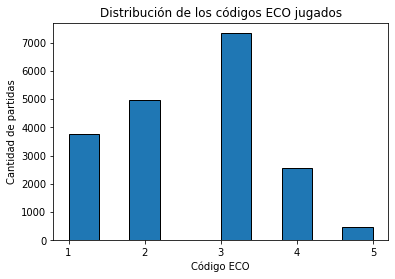

In [21]:
plt.title('Distribución de los códigos ECO jugados')
plt.xlabel('Código ECO')
plt.ylabel('Cantidad de partidas')
plt.hist(data['openingECO'],  edgecolor="k")
bins = [1,2,3,4,5]
plt.xticks(bins)
plt.show()

Como se puede apreciar, las aperturas del grupo ECO "B" y "C" son las más utilizadas. Esto concuerda con la teoría: la apertura más utilizada en ajedrez, la Española o Ruy López, tiene el código ECO C60 a C99. Las aperturas de la categoría "E", las Defensas Indias, son las menos utilizadas por los jugadores.

### 4.b Correlación entre ELO y *winner*

Con el fin de evitar una suposición común para personas ajenas al juego, se graficará un diagrama de dispersión para encontrar si hay alguna relación entre el ELO de un jugador y el resultado de la partida.

Primeramente, se grafica con el ELO de las Blancas:

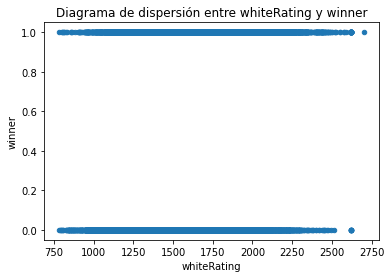

In [27]:
data.plot.scatter(y = 'winner', x = 'whiteRating', title = "Diagrama de dispersión entre whiteRating y winner");

Luego, se grafica con el ELO de las Negras:

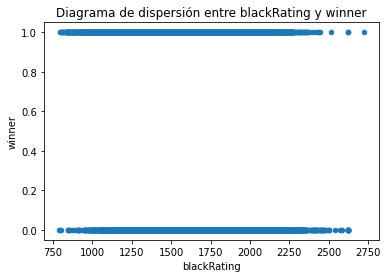

In [26]:
data.plot.scatter( x = 'blackRating', y = 'winner', title = "Diagrama de dispersión entre blackRating y winner");

Como se aprecia en los gráficos anteriores, no existe ninguna relación entre el ELO de un jugador y el valor de *winner*. Esto se debe a que, conforme aumenta el ELO, aumenta también el ELO de los rivales a los que se enfrentará, por lo que la cantidad de victorias y derrotas se mantiene, por lo general, uniforme a lo largo de los rangos de ELO.

### 4.c Particionamiento entre jugadores con más de 2000 ELO y jugadores con menos de 2000 ELO

Se desea conocer cómo cambian las aperturas utilizadas por los jugadores después de cierta fuerza de juego. Para esto, se agruparán a los jugadores de piezas Blancas en dos categorías: ELO mayor a 2000 (más fuertes) y ELO menor a 2000 (más débiles). 

Se agrupará por las piezas Blancas porque se tiene más capacidad de elegir cuál apertura jugar que con las piezas Negras. Por ejemplo, si un jugador de piezas Blancas decide jugar Peón Rey, no hay forma de que las Negras puedan llevar la partida a un código ECO "A" o "D".

Se eligió la marca de 2000 puesto que es la puntuación necesaria para alcanzar la Primera División en Costa Rica. Esto **no** quiere decir que los jugadores necesariamente tienen esa fuerza (dado que en Internet los ELOs son más altos), pero sí indica que el jugador ha dedicado un tiempo considerable al estudio del juego.



In [28]:
dataStrong = data[(data["whiteRating"] >= 2000)]
dataWeak = data[(data["whiteRating"] < 2000)]
print("Observaciones totales = ", len(data))
print("Observaciones de jugadores con ELO < 2000 = ", len(dataWeak))
print("Observaciones de jugadores con ELO >= 2000 ", len(dataStrong))

Observaciones totales =  19108
Observaciones de jugadores con ELO < 2000 =  17420
Observaciones de jugadores con ELO >= 2000  1688


Primeramente, se grafican las aperturas jugadas por los ELOs menores a 2000:

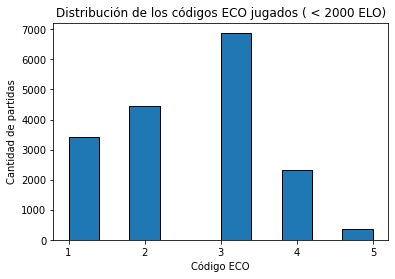

In [23]:
plt.title('Distribución de los códigos ECO jugados ( < 2000 ELO)')
plt.xlabel('Código ECO')
plt.ylabel('Cantidad de partidas')
plt.hist(dataWeak['openingECO'],  edgecolor="k")
bins = [1,2,3,4,5]
plt.xticks(bins)
plt.show()

Luego, se grafican las aperturas de los jugadores más fuertes:

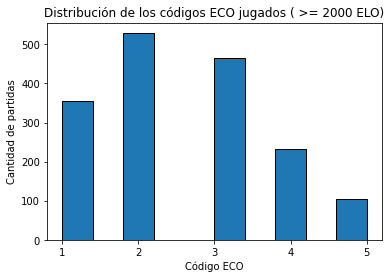

In [22]:
plt.title('Distribución de los códigos ECO jugados ( >= 2000 ELO)')
plt.xlabel('Código ECO')
plt.ylabel('Cantidad de partidas')
plt.hist(dataStrong['openingECO'],  edgecolor="k")
bins = [1,2,3,4,5]
plt.xticks(bins)
plt.show()

De los 2 gráficos anteriores se pueden extraer algunas conclusiones:

- Los jugadores más fuertes utilizan las aperturas de la categoría "E" (Defensas Indias) en mayor proporción que los más débiles. Esto se debe a que dichas aperturas son considerablemente más complejas de jugar, por lo que requieren mayor estudio para emplearlas correctamente.
- Los jugadores más débiles prefieren las aperturas de la categoría "C", mientras que los más fuertes prefieren las de la categoría "B". Esto se explica, en parte, a la adopción de la Defensa Siciliana como apertura favorita de los jugadores más experimentados; la Siciliana ocupa los códigos B20-B99.
- Las aperturas de la cateogría "D" parecen ser jugadas en igual proporción, tanto por jugadores fuertes como por jugadores débiles.

## 5. Algoritmos de aprendizaje de máquina

### 5.a Red Neuronal 

Las variables del *dataset* se resumen a continuación:

**Variables de entrada (X):**

1. isRated.
2. turns.
3. timeControl.
4. whiteRating.
5. blackRating.
6. openingECO.

**Variable de salida (Y):**
1. winner (variable de clase; 1 o 0).

Una vez cargados los datos, se pueden seleccionar las variables de entrada y, por aparte, la columna de salida:

In [35]:
X = data.iloc[:,0:6]
y = data.iloc[:, 6]

In [37]:
X.head()

,isRated,turns,timeControl,whiteRating,blackRating,openingECO
0,0,13,15,1500,1191,4
1,1,16,5,1322,1261,2
2,1,61,5,1496,1500,3
3,1,61,20,1439,1454,4
4,1,95,30,1523,1469,3


In [36]:
y.head()

0    1
1    0
2    1
3    1
4    1
Name: winner, dtype: int64

#### 5.a.1 Definir modelo de Keras

Se utilizará la siguiente arquitectura en la red:

- La capa de entrada tendrá una dimensión de 6, una neurona por cada *feature*.
- La primera capa oculta utiliza 12 nodos y la función ReLU.
- La segunda capa oculta tiene 8 nodos y la función ReLU.
- La capa de salida tiene un nodo y utiliza la función sigmoide.

In [39]:
# define the keras model
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


#### 5.a.2 Compilar el modelo Keras

Se utilizará cross entropy como la *loss function* y adam como el *optimizer*. También, puesto que se está trabajando con un problema de clasificación, se desea reportar la precisión, definida mediante el argumento metrics.

In [40]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### 5.a.3 Entrenar el modelo

Para el entrenamiento, se utilizarán 100 epochs y un batch size de 10.

In [42]:
# fit the keras model on the dataset
model.fit(X, y, epochs=100, batch_size=10)

Epoch 1/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 2/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 3/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 4/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 5/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 6/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 7/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 8/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 9/100
1911/1911 [==============================] - 3s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Epoch 10/100
1911/1911 [==============================] - 3s 1ms/step - l

#### 5.a.4 Evaluar el modelo

Para obtener una idea de qué tan bien se ha modelado el *dataset*, se puede utilizar la función *evaluate*:



In [43]:
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

598/598 [==============================] - 1s 1ms/step - loss: 0.6921 - accuracy: 0.5234
Accuracy: 52.34


Esta precisión **no** significa qué tan bien se comportará el modelo al realizar predicciones sobre datos nuevos. Para determinar ese rendimiento, se evaluará el modelo en la sección 6, utilizando *k-fold cross-validation*.

### 5.b XGBoost

Luego de tener una primera impresión del rendimiento de una red neuronal, se construye un modelo de XGBoost con los parámetros por defecto, para obtener el *baseline performance* para este algoritmo.

In [78]:
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
# define the model
model = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.717 (0.013)


En la sección 6, se modificarán sus hiperparámetros para intentar superar este rendimiento.

Como se puede observar, con los parámetros por defecto, el XGBoost alcanzó resultados considerablemente mejores que la red neuronal. Específicamente, representó una mejora del 37% en comparación con el modelo de Keras. En la siguiente sección, se utilizará *k-fold cross validation* para obtener un resultado más preciso del rendimiento de la red neuronal y se probará con diferentes hiperparámetros en el XGBoost para intentar mejorar esta *baseline performance*.

## 6. Evaluación de modelos

### 6.a K-Fold Cross Validation para la Red Neuronal

Se realizará una validación cruzada del modelo, con 10 *folds*, para determinar su rendimiento. Para esto, se reportará la precisión en cada uno de los *folds*, así como la precisión media de todas las corridas.

In [70]:
# k-fold cross-validation of base model for the mammography dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot
# prepare cross validation
kfold = StratifiedKFold(10, random_state=1)
# enumerate splits
scores = list()
#X = X.to_numpy()
#y = y.to_numpy()
for train_ix, test_ix in kfold.split(X, y):
  # split data
  X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
  # determine the number of input features
  n_features = X.shape[1]
  # define model
  model = Sequential()
  model.add(Dense(12, input_dim=6, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit the model
  model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
	# predict test set
  yhat = (model.predict(X_test) > 0.5).astype("int32")
	# evaluate predictions
  score = accuracy_score(y_test, yhat)
  print('>%.3f' % score)
  scores.append(score)
# summarize all scores
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


>0.634
>0.616
>0.659
>0.640
>0.662
>0.659
>0.645
>0.523
>0.524
>0.659
Mean Accuracy: 0.622 (0.051)


### 6.b Selección de hiperparámetros para XGBoost

#### 6.b.1 *Number of trees* y *depth*

In [89]:
# get a list of models to evaluate
def get_models():
  models = dict()
  trees = [50, 100, 500]
  for n in trees:
    for i in range(5,11):
      models[str(str(i)+" , "+str(n))] = XGBClassifier(max_depth=i,n_estimators=n)
  return models

# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scoresTreesAndDepth = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scoresTreesAndDepth

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scoresTreesAndDepth = evaluate_model(model)
	results.append(scoresTreesAndDepth)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scoresTreesAndDepth), std(scoresTreesAndDepth)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)

>5 , 50 0.706 (0.014)
>6 , 50 0.760 (0.011)
>7 , 50 0.756 (0.013)
>8 , 50 0.783 (0.012)
>9 , 50 0.776 (0.011)
>10 , 50 0.788 (0.013)
>5 , 100 0.800 (0.010)
>6 , 100 0.832 (0.015)
>7 , 100 0.832 (0.012)
>8 , 100 0.852 (0.009)
>9 , 100 0.846 (0.008)
>10 , 100 0.856 (0.008)
>5 , 500 0.892 (0.007)
>6 , 500 0.891 (0.007)
>7 , 500 0.889 (0.007)
>8 , 500 0.888 (0.007)


KeyboardInterrupt: ignored

#### 6.b.2


#### 6.b.3

## 7. Resultados

El siguiente gráfico muestra la precisión alcanzada por la red neuronal en cada una de las 10 corridas de evaluación, utilizando *k-fold cross validation*:

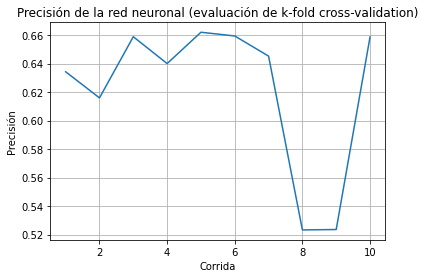

In [77]:
evaluations = [1,2,3,4,5,6,7,8,9,10]
fig, ax = plt.subplots()
ax.plot(evaluations,scores)
ax.set(xlabel='Corrida', ylabel='Precisión',
       title='Precisión de la red neuronal (evaluación de k-fold cross-validation)')
ax.grid()
plt.show()